In [1]:
import numpy as np
import torch
from GTF import *

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_dir = '/root/data1/d_0.4_EMD'
data_encode=torch.load('/root/data1/d_0.4_EMD/M_encode_output_01traj120050200ts_vis.pt')
data=copy.deepcopy(data_encode[0:30])

In [3]:
data_GA=torch.load('/root/data1/STGCN_result/GA_200_pred')
y_test=torch.load('/root/data1/STGCN_result/ST_200_pred')

In [4]:
print(len(y_test))
print(len(data_GA))

170
200


In [5]:
device='cuda'
y_ST=copy.deepcopy(data_GA)
for i in range(int(len(data_GA)-30)):
    y_ST[i+30].x=y_test[i,:,:].to(device)

In [6]:
for i in range(30):
    y_ST[i]=data[i]

In [7]:
import numpy as np
import meshio
import torch
import tensorflow.compat.v1 as tf
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import pandas as pd
import os
import time
from IPython.lib.display import isdir
import random
import matplotlib.pyplot as plt
import copy
from matplotlib import tri as mtri
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

from d_pooling import *
#from mgn import *
from d_tap_processing import *
#from global_tpok_mp import *

from d_TAP_MP_Attention import *
from GTF import *

In [8]:
number_trajectories=1
dataset_dir = '/root/data1/d_0.4_EMD'

in_channels_node =2  #2
in_channels_edge = 3  #3
hidden_channels = 26#24    #22#12
out_channels = in_channels_node
batch_size =25       #改25
n_mlp_encode = 4
n_mlp_mp = 5#5
encoding_dim=32#32
ae_dim=[160,128,64,32]#[128,64,32,16,10][300,128,64,32]
n_mp_down = [2,2,1,1]
n_mp_up= [1,1,2,2]
pool_num =[6500,4800,3900]#[2000,1500,1200,1000][2000,1600,1400,1000]

act = F.elu
param_sharing = False
pathD='/root/data1/d_0.4_EMD/Decode_state_dict.pt'

In [9]:
EDstats_list=torch.load('/root/data1/d_0.4_EMD/EDstats_list.pt')
[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = EDstats_list
(EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)=(EDmean_vec_x.to(device),
        EDstd_vec_x.to(device),EDmean_vec_edge.to(device),EDstd_vec_edge.to(device))

In [ ]:
i=0
batches=torch.load(dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'batches.pt')
xs=torch.load(dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'xs.pt')
positions=torch.load( dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'positions.pt')
edge_attrs=torch.load( dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'edge_attrs.pt')
edge_indices=torch.load( dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'edge_indices.pt')
edge_masks=torch.load(dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'edge_masks.pt')


perm_list=torch.load(dataset_dir+'/perm_list_150.pt')




decode_model=GNN_Decode(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')
decode_model.load_state_dict(torch.load(pathD), strict=False)
decode_model.to(device)

pred_ST_x=[]
with torch.no_grad():
        for i in range(len(y_ST)):
              x=decode_model(y_ST[i], batches , xs, positions, edge_attrs, edge_indices, edge_masks,perm_list[0])
              x=x*EDstd_vec_x+EDmean_vec_x
              pred_ST_x.append(x)
              
print(len(pred_ST_x))

200


In [11]:
def ROM_transform_vector(data, satart_number_ts,number_ts, originalFolder, destinationFolder, fileName):

    folder = os.path.exists(destinationFolder)

    if not folder: 
        print('start to create the destination folder')   
        os.makedirs(destinationFolder)       
        copyFiles(originalFolder,destinationFolder) 

    print('start to store data as a new variable')
    
    for i in range(number_ts):
        f_filename = destinationFolder + fileName + str(i+satart_number_ts)+ ".vtk"
        reader=vtk.vtkPolyDataReader()
        reader.SetFileName(f_filename)  # SetFileName设置要读取的vtk文件
        reader.ReadAllScalarsOn()
        reader.ReadAllVectorsOn()
        reader.ReadAllTensorsOn()
        reader.Update()

        vtkdata=reader.GetOutput()  # GetOutput获取文件的数据
        num_points=vtkdata.GetNumberOfPoints() 
        point_data =vtkdata.GetPointData()
        a=data[i]
        a=a.to('cpu')
        a=a.numpy()
    
        velocity_array = point_data.GetArray('U')
        #print(velocity_array.GetTuple(0)[0:2])
        for j in range(num_points):
            original_velocity = list(velocity_array.GetTuple(j))
            original_velocity[0:2]=tuple(a[j])
            velocity_array.SetTuple(j, original_velocity)

        writer = vtk.vtkGenericDataObjectWriter()
        writer.SetFileName(f_filename)
        writer.SetInputData(vtkdata)
        writer.Write()
       
    print('transform succeed')

In [12]:
for i in range(number_trajectories):
    satart_number_ts=50
    ts=len(pred_ST_x)
    originalFolder='/root/data1/d_slice_'+str(i)
    destinationFolder='/root/data1/STGCN_result/ST_ROM_d_0.4_dataset_EDoutput_1900'
    fileName="/slice_"
    ROM_transform_vector(pred_ST_x, satart_number_ts,ts, originalFolder, destinationFolder, fileName)

start to create the destination folder
start to store data as a new variable
transform succeed


In [13]:
def cc(ori_data, rom_data_0, rom_data_1):
    pcc_0 = pearson_value(ori_data, rom_data_0)
    pcc_1 = pearson_value(ori_data, rom_data_1)
    
    fig, ax = plt.subplots()
    x = np.linspace(0,pcc_0.shape[0],pcc_0.shape[0])
    print(pcc_0.shape, pcc_1.shape)
    ax.set_prop_cycle(color = ['#f6b93b','#6a89cc','#82ccdd'], linestyle = ['-', '-', '-'])
    y_0 = pcc_0
    y_1 = pcc_1
   
   
    ax.plot(x, y_0, x, y_1)
     
            # plt.xlim((-0.1, 200.1))# range
    plt.ylim((0.8, 1))
    plt.xlabel('Time Level',{'size' : 11})
    plt.ylabel('Pearson Correlation Coefficient',{'size' : 11})
            # plt.xticks(np.arange(0,200.1,25))
            # plt.yticks(np.arange(0.97,1.0001,0.01))
            # plt.legend(['D4:AE+TF', 'D8:AE+TF', 'D12:AE+TF', 'D4:PCA+TF', 'D8:PCA+TF', 'D12:PCA+TF'], loc='lower right')   
    plt.legend(['ST', 'GA'], loc='lower right')   

    plt.show()
    fig.savefig('/root/data1/STGCN_result/'+'Pcc.pdf', bbox_inches='tight')

200
(200, 15586) (200, 15586) (200, 15586)
(200, 1) (200, 1)


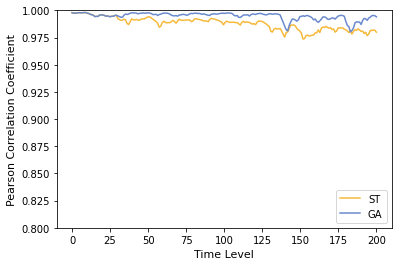

In [14]:
ED_out_1 = pred_ST_x
ED_out_2 = pred_GA_x

number_ts=200
ori=torch.load('/root/data1/d_0.4_EMD/meshgraphnets_miniset111traj50200ts_vis.pt')
print(len(ori))   #200


for i in range(number_ts):
    
   
    uvw_1=ED_out_1[i].reshape(1,ED_out_1[i].shape[0],ED_out_1[i].shape[1]).to('cpu')
    uvw_2=ED_out_2[i].reshape(1,ED_out_2[i].shape[0],ED_out_2[i].shape[1]).to('cpu')
    
    ouvw=ori[i].x.reshape(1,ori[i].x.shape[0],ori[i].x.shape[1])
    
    outputs_1 = uvw_1 if i==0 else np.vstack((outputs_1,uvw_1))
    outputs_2 = uvw_2 if i==0 else np.vstack((outputs_2,uvw_2))
    inputs=ouvw if i==0 else np.vstack((inputs,ouvw))


output_1 = np.hstack((outputs_1[:,:,0],outputs_1[:,:,1]))
output_2 = np.hstack((outputs_2[:,:,0],outputs_2[:,:,1]))
input_ = np.hstack((inputs[:,:,0],inputs[:,:,1]))
print(output_1.shape,output_2.shape,input_.shape)

cc(input_, output_1, output_2)

In [15]:
from keras import backend as K

In [16]:
def root_mean_squared_error(true, pred):
    return K.mean(K.square(pred - true))
def rmse(ori_data, rom_data):

    rmse_value = []
    if len(ori_data) != len(rom_data):
        print('the length of these two array do not match')
    else:
        for i in range(len(rom_data)):
            value = root_mean_squared_error(ori_data[i], rom_data[i])

            ori=torch.Tensor(ori_data[i])
            
            k=((torch.norm(ori, p=1))/len(ori))
            
            #value =acc(ori, rom)
            
            #value =math.sqrt(acc(ori, rom))
            value=math.sqrt(value)/k

            if i == 0:
                rmse_value = value
            else:
                rmse_value = np.hstack((rmse_value,value))
        rmse_value = np.reshape(rmse_value,(-1,1))
    return rmse_value
def rmse_over_time(ori_data, rom_data_0, rom_data_1):
    rmse_0 = rmse(ori_data, rom_data_0)
    rmse_1 = rmse(ori_data, rom_data_1)
    
  
    # rmse_4 = rmse(ori_data, rom_data_4)
    # rmse_5 = rmse(ori_data, rom_data_5)
 
    # plt.figure(1)
    # x = np.linspace(5,8,600)

    fig, ax = plt.subplots()
    x = np.linspace(0,rmse_0.shape[0],rmse_0.shape[0])
    ax.set_prop_cycle(color = ['#f6b93b','#6a89cc'], linestyle = ['-', '-'])
    # x = np.linspace(0,15,2875)
    y_0 = rmse_0
    y_1 = rmse_1
    
   
    # y_4 = rmse_4[-1800:-1200,:]
    # y_5 = rmse_5[-1800:-1200,:]
    # plt.title('Correlation Coefficient')
    ax.plot(x, y_0, x, y_1)
    # , x, rmse_4, linewidth = 0.6)
    # plt.xlim((-0.1, 200.1))# range
    plt.ylim((-0.005, 1))
    plt.xlabel('Time Level',{'size' : 11})
    plt.ylabel('RRMSE',{'size' : 11})
    # plt.xticks(np.arange(0,200.1,25))
    # plt.yticks(np.arange(0,0.081,0.02))
    plt.legend(['ST', 'GA'], loc='upper right')   
    plt.show()
    fig.savefig('/root/data1/STGCN_result/'+'RRMSE.pdf', bbox_inches='tight')

2024-11-19 11:09:53.668944: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-19 11:09:53.685048: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15922 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:9e:00.0, compute capability: 8.9


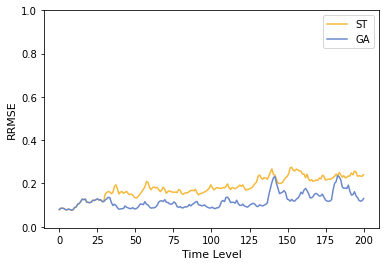

In [17]:
rmse_over_time(input_, output_1, output_2)

在200-310，110 time level

In [13]:
import numpy as np
import meshio
import torch
import tensorflow.compat.v1 as tf
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import pandas as pd
import os
import time
from IPython.lib.display import isdir
import random
import matplotlib.pyplot as plt
import copy
from matplotlib import tri as mtri
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

from d_pooling import *
#from mgn import *
from d_tap_processing import *
#from global_tpok_mp import *

from d_TAP_MP_Attention import *
from GTF import *

In [14]:
per_t=1     
satart_number_ts=200
number_ts=31
batch_size = int(number_ts/per_t)
dataset_dir = '/root/data1/d_0.4_EMD'
path='/root/data1/d_slice_'     #将文件命名为yuan_0
number_trajectories=1
device='cuda'

#get_dataset(number_trajectories,satart_number_ts,number_ts,per_t,batch_size,dataset_dir,path)

file_path= dataset_dir+'/meshgraphnets_miniset'+str(per_t)+str(batch_size)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt'
dataset_M = torch.load(file_path)
print(len(dataset_M))   #长度为1  

perm_list=torch.load(dataset_dir+'/perm_list_150.pt')

print(device)
for i in range(len(perm_list[0])):
   
    perm_list[0][i]=perm_list[0][i].to(device)
print(perm_list[0][0].device)
pathE='/root/data1/d_0.4_EMD/Encode_state_dict.pt'

in_channels_node = 2 #2
in_channels_edge = 3 #3
hidden_channels = 26#24    #22#12
out_channels = in_channels_node

n_mlp_encode = 4
n_mlp_mp = 5#5
encoding_dim=32#32
ae_dim=[160,128,64,32]#[128,64,32,16,10][300,128,64,32]
n_mp_down = [2,2,1,1]
n_mp_up= [1,1,2,2]
pool_num =[6500,4800,3900]#[2000,1500,1200,1000][2000,1600,1400,1000]

[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = torch.load(dataset_dir+'/EDstats_list.pt')

(EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)=(EDmean_vec_x.to(device),
        EDstd_vec_x.to(device),EDmean_vec_edge.to(device),EDstd_vec_edge.to(device))

act = F.elu
param_sharing = False

1
cuda
cuda:0


In [15]:

M_encode=GNN_topk_encode(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')
M_encode.to(device)
M_encode.load_state_dict(torch.load(pathE), strict=False)




with torch.no_grad():
  for i in range(len(dataset_M)):
    dataset_M[i]=dataset_M[i].to(device)
    data_list,batches , xs, positions, edge_attrs, edge_indices, edge_masks= M_encode(dataset_M[i], per_t , perm_list[0],
                                                                                            batch_size,EDmean_vec_x,EDstd_vec_x,
                                                                                            EDmean_vec_edge,EDstd_vec_edge,
                                                                                            batch=None, return_mask=False)  
    torch.save(data_list,dataset_dir+'/M_encode_output_'+str(i)+str(number_trajectories)+'traj'+str(per_t)+str(batch_size)+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
    torch.save(batches,dataset_dir+'/'+str(satart_number_ts)+str(number_ts)+str(i)+str(number_trajectories)+'traj'+'batches.pt')
    torch.save(xs,dataset_dir+'/'+str(satart_number_ts)+str(number_ts)+str(i)+str(number_trajectories)+'traj'+'xs.pt')
    torch.save( positions,dataset_dir+'/'+str(satart_number_ts)+str(number_ts)+str(i)+str(number_trajectories)+'traj'+'positions.pt')
    torch.save( edge_attrs,dataset_dir+'/'+str(satart_number_ts)+str(number_ts)+str(i)+str(number_trajectories)+'traj'+'edge_attrs.pt')
    torch.save( edge_indices,dataset_dir+'/'+str(satart_number_ts)+str(number_ts)+str(i)+str(number_trajectories)+'traj'+'edge_indices.pt')
    torch.save( edge_masks,dataset_dir+'/'+str(satart_number_ts)+str(number_ts)+str(i)+str(number_trajectories)+'traj'+'edge_masks.pt')
    
    print(len(data_list))#30
    print(data_list[0],data_list[1],data_list[2],data_list[3],data_list[4],data_list[5])

31
Data(x=[3900, 26], edge_index=[2, 14586], edge_attr=[14586, 26]) Data(x=[3900, 26], edge_index=[2, 14586], edge_attr=[14586, 26]) Data(x=[3900, 26], edge_index=[2, 14586], edge_attr=[14586, 26]) Data(x=[3900, 26], edge_index=[2, 14586], edge_attr=[14586, 26]) Data(x=[3900, 26], edge_index=[2, 14586], edge_attr=[14586, 26]) Data(x=[3900, 26], edge_index=[2, 14586], edge_attr=[14586, 26])


In [16]:
import tensorflow.compat.v1 as tf
import torch
from STGCN import *
import scipy.sparse as sp

In [17]:
dataset_encode=torch.load('/root/data1/d_0.4_EMD/M_encode_output_01traj120050200ts_vis.pt')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_frame=31
n_his=30
n=dataset_encode[0].x.shape[0]
C0=dataset_encode[0].x.shape[1]
edge_index=dataset_encode[0].edge_index
data=seq_gen(dataset_encode,  n_frame)#(190,11,n,C)
n_train=150
n_val=20
Ks=3
Kt=5
batch_size=10
epoch=300
opt='RMSProp'
lr=1e-3
save_=5
blocks = [[C0, 32, 64], [64, 32, 128]]

inputs,x_stats=data_gen(data, n_train, n_val)

In [18]:
n_frame=31
data_test=seq_gen(data_list[0:n_frame],  n_frame)#[1,21,n,c0]
print(data_test.shape) #([1, 31, 3900, 26]
x_test = z_score(data_test, x_stats['mean'], x_stats['std'])
n_pred=80
y_test=model_test(x_test, x_stats,  n_his, n_pred, load_path='/root/data1/STGCN_result/saved_model/')#逆标准化
print(y_test.shape)#(180,n,c0)

torch.Size([1, 31, 3900, 26])
INFO:tensorflow:Restoring parameters from /root/data1/STGCN_result/saved_model/model.ckpt


2024-11-19 20:28:52.851795: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-19 20:28:52.865507: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18366 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:9e:00.0, compute capability: 8.9


>> Loading saved model from /root/data1/STGCN_result/saved_model/model.ckpt ...


2024-11-19 20:28:55.185900: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8202
2024-11-19 20:28:56.130900: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-19 20:28:56.134841: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-11-19 20:28:56.134863: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at /usr/local/cuda/bin/ptxas
2024-11-19 20:28:56.134957: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: /usr/local/cuda/bin/ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-11-19 20:28:56.861019: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only b

(80, 3900, 26)
Testing model finished!
torch.Size([80, 3900, 26])


In [19]:
torch.save(y_test,'/root/data1/STGCN_result/ST_110_pred')

In [20]:
data_GA=torch.load('/root/data1/STGCN_result/GA_d_0.4_110_pred')
y_test=torch.load('/root/data1/STGCN_result/ST_110_pred')

In [21]:
print(data_GA[0])
print(len(data_GA))
print(len(y_test))

Data(x=[3900, 26], edge_index=[2, 14586], edge_attr=[14586, 26])
110
80


In [22]:
device='cuda'
y_ST=copy.deepcopy(data_GA)
for i in range(int(len(data_GA)-30)):
    y_ST[i+30].x=y_test[i,:,:].to(device)

In [23]:
for i in range(30):
    y_ST[i]=data_list[i]

In [24]:
decode_model=GNN_Decode(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')
pathD='/root/data1/d_0.4_EMD/Decode_state_dict.pt'
decode_model.load_state_dict(torch.load(pathD), strict=False)
decode_model.to(device)

i=0
batches=torch.load(dataset_dir+'/'+str(satart_number_ts)+str(number_ts)+str(i)+str(number_trajectories)+'traj'+'batches.pt')
xs=torch.load(dataset_dir+'/'+str(satart_number_ts)+str(number_ts)+str(i)+str(number_trajectories)+'traj'+'xs.pt')
positions=torch.load( dataset_dir+'/'+str(satart_number_ts)+str(number_ts)+str(i)+str(number_trajectories)+'traj'+'positions.pt')
edge_attrs=torch.load( dataset_dir+'/'+str(satart_number_ts)+str(number_ts)+str(i)+str(number_trajectories)+'traj'+'edge_attrs.pt')
edge_indices=torch.load( dataset_dir+'/'+str(satart_number_ts)+str(number_ts)+str(i)+str(number_trajectories)+'traj'+'edge_indices.pt')
edge_masks=torch.load(dataset_dir+'/'+str(satart_number_ts)+str(number_ts)+str(i)+str(number_trajectories)+'traj'+'edge_masks.pt')




perm_list=torch.load(dataset_dir+'/perm_list_150.pt')


pred_ST_x=[]
with torch.no_grad():
        for i in range(len(y_ST)):
              x=decode_model(y_ST[i], batches , xs, positions, edge_attrs, edge_indices, edge_masks,perm_list[0])
              x=x*EDstd_vec_x+EDmean_vec_x
              pred_ST_x.append(x)

              
print(len(pred_ST_x))



110


In [25]:
def ROM_transform_vector(data, satart_number_ts,number_ts, originalFolder, destinationFolder, fileName):

    folder = os.path.exists(destinationFolder)

    if not folder: 
        print('start to create the destination folder')   
        os.makedirs(destinationFolder)       
        copyFiles(originalFolder,destinationFolder) 

    print('start to store data as a new variable')
    
    for i in range(number_ts):
        f_filename = destinationFolder + fileName + str(i+satart_number_ts)+ ".vtk"
        reader=vtk.vtkPolyDataReader()
        reader.SetFileName(f_filename)  # SetFileName设置要读取的vtk文件
        reader.ReadAllScalarsOn()
        reader.ReadAllVectorsOn()
        reader.ReadAllTensorsOn()
        reader.Update()

        vtkdata=reader.GetOutput()  # GetOutput获取文件的数据
        num_points=vtkdata.GetNumberOfPoints() 
        point_data =vtkdata.GetPointData()
        a=data[i]
        a=a.to('cpu')
        a=a.numpy()
    
        velocity_array = point_data.GetArray('U')
        #print(velocity_array.GetTuple(0)[0:2])
        for j in range(num_points):
            original_velocity = list(velocity_array.GetTuple(j))
            original_velocity[0:2]=tuple(a[j])
            velocity_array.SetTuple(j, original_velocity)

        writer = vtk.vtkGenericDataObjectWriter()
        writer.SetFileName(f_filename)
        writer.SetInputData(vtkdata)
        writer.Write()
       
    print('transform succeed')

In [26]:
for i in range(number_trajectories):
    satart_number_ts=200
    ts=len(pred_ST_x)
    originalFolder='/root/data1/d_slice_'+str(i)
    destinationFolder='/root/data1/STGCN_result/ST_pred_ROM_d_0.4_dataset_EDoutput_'+str(ts)+str(i)
    fileName="/slice_"
    ROM_transform_vector(pred_ST_x, satart_number_ts,ts, originalFolder, destinationFolder, fileName)

start to create the destination folder
start to store data as a new variable
transform succeed


In [27]:
def cc(ori_data, rom_data_0, rom_data_1):
    pcc_0 = pearson_value(ori_data, rom_data_0)
    pcc_1 = pearson_value(ori_data, rom_data_1)
    
    fig, ax = plt.subplots()
    x = np.linspace(0,pcc_0.shape[0],pcc_0.shape[0])
    print(pcc_0.shape, pcc_1.shape)
    ax.set_prop_cycle(color = ['#f6b93b','#6a89cc','#82ccdd'], linestyle = ['-', '-', '-'])
    y_0 = pcc_0
    y_1 = pcc_1
   
   
    ax.plot(x, y_0, x, y_1)
     
            # plt.xlim((-0.1, 200.1))# range
    plt.ylim((0.8, 1))
    plt.xlabel('Time Level',{'size' : 11})
    plt.ylabel('Pearson Correlation Coefficient',{'size' : 11})
            # plt.xticks(np.arange(0,200.1,25))
            # plt.yticks(np.arange(0.97,1.0001,0.01))
            # plt.legend(['D4:AE+TF', 'D8:AE+TF', 'D12:AE+TF', 'D4:PCA+TF', 'D8:PCA+TF', 'D12:PCA+TF'], loc='lower right')   
    plt.legend(['ST', 'GA'], loc='lower right')   

    plt.show()
    fig.savefig('/root/data1/STGCN_result/'+'test_Pcc.pdf', bbox_inches='tight')

In [28]:
def get(number_trajectories,satart_number_ts,number_ts,per_t,batch_size,path):
  data_list = []

  for i in range(number_trajectories):

    if os.path.isdir(path):
      path_k=path
      print(path_k)
      vtk_num=get_vtk_num(path_k)
      print(vtk_num)
      for ts in range(satart_number_ts,vtk_num):
        
        if(ts==number_ts+satart_number_ts):
          break
        point, cells, velocity=read_vtk_file(path_k+"/slice_"+str(ts+i)+".vtk")
        
        data_list.append(Data(x=velocity))
  return data_list

In [29]:
dataset_dir = '/root/data1/d_0.4_EMD'
number_trajectories=1
satart_number_ts=200
number_ts=110
path_2='/root/data1/ROM_pred_d_0.4_dataset_EDoutput_1000'
ED_out_2=get(number_trajectories,satart_number_ts,number_ts,1,1,path_2)
#print(ED_out_2)
print(len(ED_out_2))
ED_out_2=ED_out_2[0:110]

/root/data1/ROM_pred_d_0.4_dataset_EDoutput_1000
601
110


110
(110, 15586) (110, 15586) (110, 15586)
(110, 1) (110, 1)


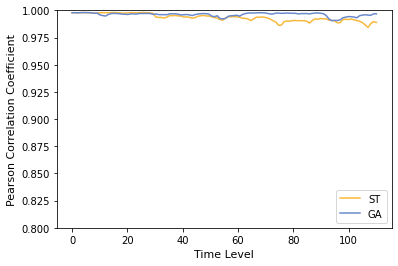

In [30]:
ED_out_1 = pred_ST_x
number_ts=110
ori=torch.load('/root/data1/d_0.4_EMD/meshgraphnets_miniset111traj200110ts_vis.pt')
print(len(ori))   #110


for i in range(number_ts):
    
   
    uvw_1=ED_out_1[i].reshape(1,ED_out_1[i].shape[0],ED_out_1[i].shape[1]).to('cpu')
    uvw_2=ED_out_2[i].x.reshape(1,ED_out_2[i].x.shape[0],ED_out_2[i].x.shape[1]).to('cpu')
    
    ouvw=ori[i].x.reshape(1,ori[i].x.shape[0],ori[i].x.shape[1])
    
    outputs_1 = uvw_1 if i==0 else np.vstack((outputs_1,uvw_1))
    outputs_2 = uvw_2 if i==0 else np.vstack((outputs_2,uvw_2))
    inputs=ouvw if i==0 else np.vstack((inputs,ouvw))


output_1 = np.hstack((outputs_1[:,:,0],outputs_1[:,:,1]))
output_2 = np.hstack((outputs_2[:,:,0],outputs_2[:,:,1]))
input_ = np.hstack((inputs[:,:,0],inputs[:,:,1]))
print(output_1.shape,output_2.shape,input_.shape)

cc(input_, output_1, output_2)

In [ ]:
from keras import backend as K
def root_mean_squared_error(true, pred):
    return K.mean(K.square(pred - true))
def rmse(ori_data, rom_data):

    rmse_value = []
    if len(ori_data) != len(rom_data):
        print('the length of these two array do not match')
    else:
        for i in range(len(rom_data)):
            value = root_mean_squared_error(ori_data[i], rom_data[i])

            ori=torch.Tensor(ori_data[i])
            
            k=((torch.norm(ori, p=1))/len(ori))
            
            #value =acc(ori, rom)
            
            #value =math.sqrt(acc(ori, rom))
            value=math.sqrt(value)/k

            if i == 0:
                rmse_value = value
            else:
                rmse_value = np.hstack((rmse_value,value))
        rmse_value = np.reshape(rmse_value,(-1,1))
    return rmse_value
def rmse_over_time(ori_data, rom_data_0, rom_data_1):
    rmse_0 = rmse(ori_data, rom_data_0)
    rmse_1 = rmse(ori_data, rom_data_1)
    
  
    # rmse_4 = rmse(ori_data, rom_data_4)
    # rmse_5 = rmse(ori_data, rom_data_5)
 
    # plt.figure(1)
    # x = np.linspace(5,8,600)

    fig, ax = plt.subplots()
    x = np.linspace(0,rmse_0.shape[0],rmse_0.shape[0])
    ax.set_prop_cycle(color = ['#f6b93b','#6a89cc'], linestyle = ['-', '-'])
    # x = np.linspace(0,15,2875)
    y_0 = rmse_0
    y_1 = rmse_1
    
   
    # y_4 = rmse_4[-1800:-1200,:]
    # y_5 = rmse_5[-1800:-1200,:]
    # plt.title('Correlation Coefficient')
    ax.plot(x, y_0, x, y_1)
    # , x, rmse_4, linewidth = 0.6)
    # plt.xlim((-0.1, 200.1))# range
    plt.ylim((-0.005, 1))
    plt.xlabel('Time Level',{'size' : 11})
    plt.ylabel('RRMSE',{'size' : 11})
    # plt.xticks(np.arange(0,200.1,25))
    # plt.yticks(np.arange(0,0.081,0.02))
    plt.legend(['ST', 'GA'], loc='upper right')   
    plt.show()
    fig.savefig('/root/data1/STGCN_result/'+'test_RRMSE.pdf', bbox_inches='tight')

2024-11-19 13:15:09.418410: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-19 13:15:09.436819: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13012 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:9e:00.0, compute capability: 8.9


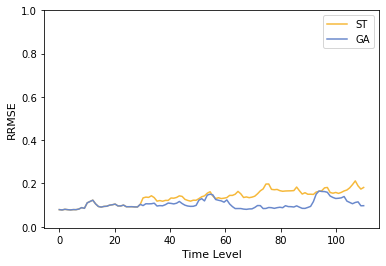

In [21]:
rmse_over_time(input_, output_1, output_2)